In [1]:
# using Pkg
# Pkg.add("Images")
# Pkg.add("MAT")

using MAT
using Plots
using Images


pyplot()

file = matopen("project_data.mat")
img = read(file, "im")
sources = read(file,"sources")
rgb = read(file,"rgb")
close(file)

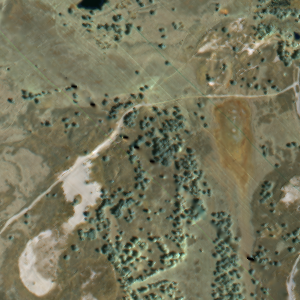

In [2]:
# visualize data in rgb (using bands 67,109,141 as th RGB channels)
p1 = colorview(RGB,permutedims(rgb,(3,1,2))) # convert 3d array to the image format used by julia

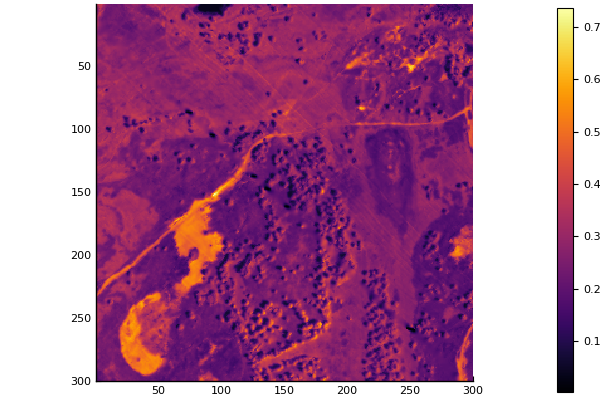

In [3]:
#visualize a spectral band on its own
heatmap(img[:,:,67],aspect_ratio=1, yflip = true,c=:inferno, label=:none)

In [4]:
size(sources)

(255, 4)

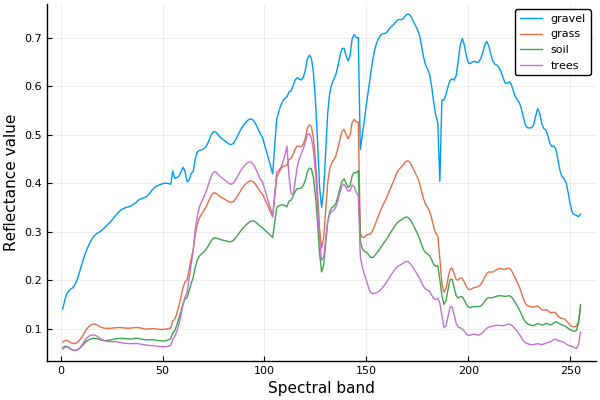

In [5]:
# visualize the endmembers to be used

plot(sources[:,1],label = "gravel")
plot!(sources[:,2],label = "grass")
plot!(sources[:,3],label = "soil")
plot!(sources[:,4],label = "trees")
xlabel!("Spectral band")
ylabel!("Reflectance value")

# Unmixing the image

The model we are using to decompose the image into the sum of the contributions of the endmembers is:

\begin{equation*}
\mathbf{X} = \mathbf{S}\mathbf{A} + \mathbf{E} 
\end{equation*}

 $\mathbf{X}\in \mathbb{R}^{L\times N}$ : data matrix
 
 $\mathbf{S}\in \mathbb{R}^{L\times P}$ : endmember matrix
 
 $\mathbf{A}\in \mathbb{R}^{P\times N}$ : abundance matrix
 
 $\mathbf{E}\in \mathbb{R}^{L\times N}$ : additive noise matrix
 
 where $L$ is the number of spectral bands, $P$ is the number of materials, and $N$ is the number of pixels
 
 The hyperspectral image is represented as a matrix with $N$ pixels, so the first thing to do is to reshape the image to a big matrix.

We can try and estimate the abundance matrix using a least squares formulation:

\begin{equation*}
\hat{A} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2}||\mathbf{X}-\mathbf{SA}||_{F}^{2} = \underset{\mathbf{A}>\mathbf{0}, \mathbf{1}_{P}^T \mathbf{A} = \mathbf{1}_{N}^{T} }{\textrm{arg min}}\frac{1}{2} \sum_{i=1}^{N} ||\mathbf{x}_{n}-\mathbf{S}\mathbf{a}_{n}||_{2}^{2}
\end{equation*}

where $\mathbf{1}_{.}$ is a vector of ones whose size is given in index 

Choose an algorithm to solve the optimization problem, and implement it both in a serial version and a version parallelized across the pixels.

In [137]:
#img_small = img[1:20,1:20,:]; # use a small crop of the image first
img_small = img
# img_small = copy(img);
size(img_small)


(300, 300, 255)

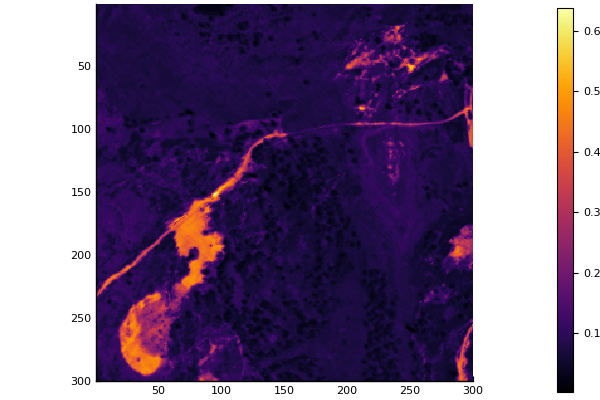

In [138]:
heatmap(img_small[:,:,50],aspect_ratio=1, yflip = true,c=:inferno, label=:none)

In [139]:
N = size(img_small)[1]
X = reshape(img_small,N*N,255)';

In [140]:
size(img_small)

(300, 300, 255)

## Optimization with libraries

In [147]:
using Convex
using ECOS
using LinearAlgebra: norm

function MSE(A,b)
    # Minimize ||Ax - b||^2 subject to x >= 0
    x = Variable(size(A)[2])
    p = Convex.minimize(sumsquares(A*x-b))
    p.constraints += x >= 0
    Convex.solve!(p, ECOSSolver(verbose=0))
    return x.value
end

MSE (generic function with 1 method)

In [148]:
# Generate random problem data
p = 4
a = zeros(p,N*N)
@time begin
    for j =1:N*N
        S = sources; 
        xi = X[:,j];
        a[:,j] = MSE(S,xi);
        a[:,j] = a[:,j]./norm(a[:,j])
    end
end

171.005727 seconds (204.00 M allocations: 44.416 GiB, 4.26% gc time)
done!

In [150]:
a_lib = a;

In [154]:
A1 = reshape(a_lib[1,:],N,N);
A2 = reshape(a_lib[2,:],N,N);
A3 = reshape(a_lib[3,:],N,N);
A4 = reshape(a_lib[4,:],N,N);

In [155]:
f2 = heatmap(A1,aspect_ratio=1, yflip = true,c=:inferno);
f3 = heatmap(A2,aspect_ratio=1, yflip = true,c=:inferno);
f4 = heatmap(A3,aspect_ratio=1, yflip = true,c=:inferno);
f5 = heatmap(A4,aspect_ratio=1, yflip = true,c=:inferno);

In [156]:
p=plot(f2,f3,f4,f5,layout=(2,2), axis=nothing, border=:none, size=(1000,1000));
p.subplots[1].attr[:title]="Gravel";
p.subplots[2].attr[:title]="Grass";
p.subplots[3].attr[:title]="Soil";
p.subplots[4].attr[:title]="Trees";

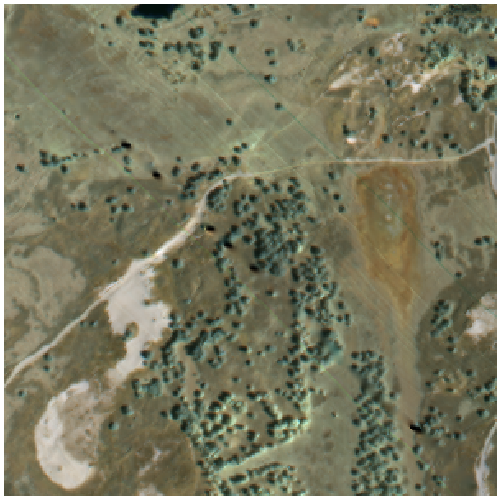

In [158]:
p1 = colorview(RGB,permutedims(rgb,(3,1,2)));
plot(p1, axis=nothing, border=:none, size=(500,500))

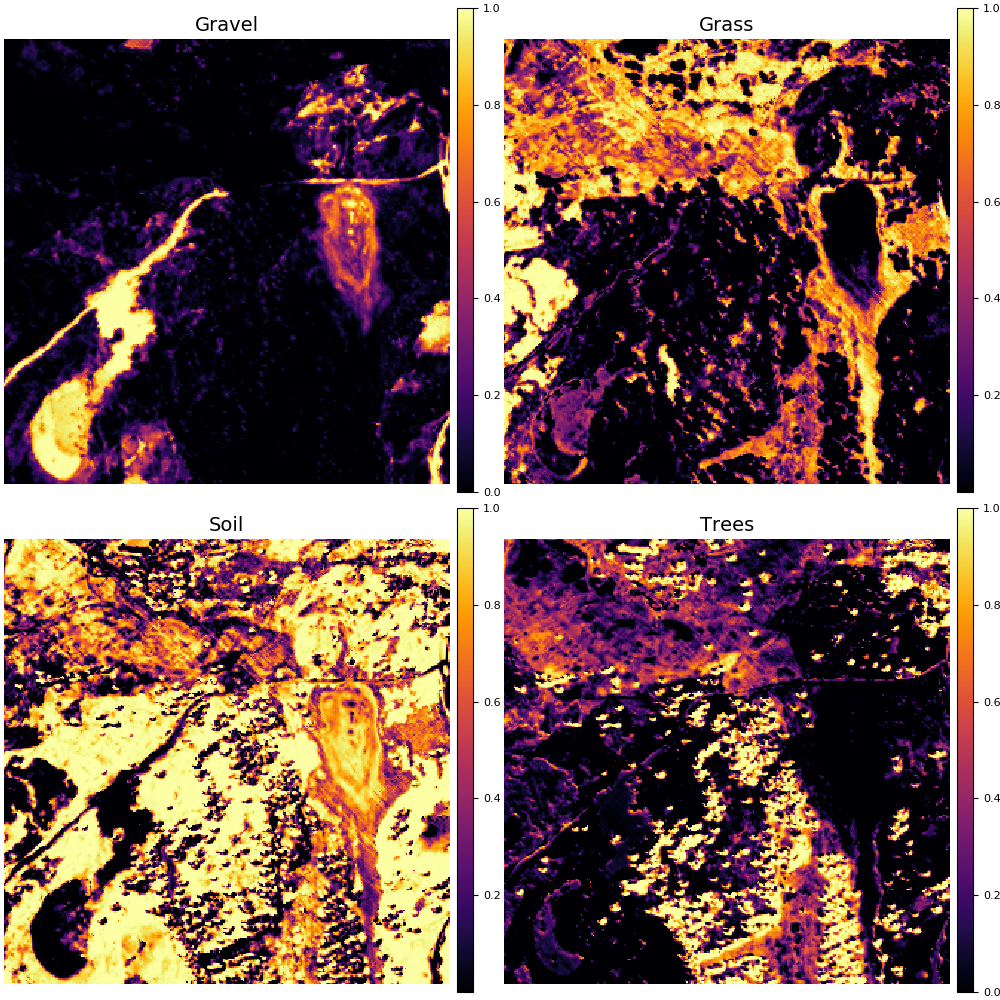

In [157]:
p

## Projected gradient descent

In [ ]:
function ProjectedGradient(f,∇f,t,N)
    pt             = max.(zeros(N),randn(N))
    nb_iter_grad   = 0  # number of loops
    resu_grad      = pt
    precision = 10^-6
    max_iter = 6000
    delta = 1
    
    while norm(delta)>precision && nb_iter_grad<max_iter
        
        nb_iter_grad  += 1;
        yt = pt-t*∇f(pt)
        # Projection
        pt_new = max.(zeros(N),yt)
        
        delta = norm(pt-pt_new)
        pt = pt_new
        resu_grad = [resu_grad pt];
    end
    return pt
end

In [ ]:
using LinearAlgebra: opnorm

p = 4
a_hat = zeros(p,N*N)
S = sources

optimal_stepsize = 2/opnorm(S'*S) #The stepsize is set to two times the reciprocal of the smallest Lipschitz constant

println("optimal stepsize: ", optimal_stepsize)

@time begin
    for j =1:N*N
        
        xi = X[:,j];
        opt = a[:,j]
        
        f(y::Vector)= (1/2)*(norm(S*y-xi))^2
        ∇f(y::Vector)= S'*(S*y-xi)

        a_hat[:,j] = ProjectedGradient(f,∇f,optimal_stepsize,4);
        a_hat[:,j] = a_hat[:,j]./norm(a_hat[:,j]);
    end
end
print("done!")

In [ ]:
A1 = reshape(a_hat[1,:],N,N);
A2 = reshape(a_hat[2,:],N,N);
A3 = reshape(a_hat[3,:],N,N);
A4 = reshape(a_hat[4,:],N,N);

In [ ]:
f1 = heatmap(img_small[:,:,67],aspect_ratio=1, yflip = true,c=:inferno, colorbar=:none)
f2 = heatmap(A1,aspect_ratio=1, yflip = true,c=:inferno, colorbar=:none)
f3 = heatmap(A2,aspect_ratio=1, yflip = true,c=:inferno, colorbar=:none)
f4 = heatmap(A3,aspect_ratio=1, yflip = true,c=:inferno, colorbar=:none)
f5 = heatmap(A4,aspect_ratio=1, yflip = true,c=:inferno, colorbar=:none)
plot(f1)

In [ ]:
plot(f2,f3,f4,f5,layout=(2,2))

# Parallel computing

In [10]:
using Distributed

CPU_CORES = length(Sys.cpu_info())

println("CPU cores: ", CPU_CORES)

# Before adding workers.
nprocs()
nworkers() # when there is no extra workers, nprocs() = nworkers().

# After adding them.
addprocs(CPU_CORES - 1)
nprocs()
nworkers()
workers()

CPU cores: 4


3-element Array{Int64,1}:
 2
 3
 4

In [11]:
@everywhere using LinearAlgebra: opnorm, norm
@everywhere using MAT

@everywhere file = matopen("project_data.mat")
@everywhere S = read(file,"sources")
@everywhere n = 4

## Parallelization with libraries

In [12]:
@everywhere using Convex
@everywhere using ECOS
@everywhere using LinearAlgebra: norm

@everywhere function parallel_MSE(A,b)
    # Minimize ||Ax - b||^2 subject to x >= 0
    x = Variable(size(A)[2])
    p = Convex.minimize(sumsquares(A*x-b))
    p.constraints += x >= 0
    Convex.solve!(p, ECOSSolver(verbose=0))
    return x.value
end

In [141]:
X_parallel = [X[:,k] for k = 1:N*N];

A = @time pmap(xi->parallel_MSE(S,xi),X_parallel);

 67.078085 seconds (8.95 M allocations: 518.612 MiB, 0.73% gc time)


In [142]:
a_hat_par_lib = permutedims(reshape(hcat(A...), (length(A[1]), length(A))));

A1 = reshape(a_hat_par_lib[:,1],N,N);
A2 = reshape(a_hat_par_lib[:,2],N,N);
A3 = reshape(a_hat_par_lib[:,3],N,N);
A4 = reshape(a_hat_par_lib[:,4],N,N);

In [143]:
f2 = heatmap(A1,aspect_ratio=1, yflip = true,c=:inferno);
f3 = heatmap(A2,aspect_ratio=1, yflip = true,c=:inferno);
f4 = heatmap(A3,aspect_ratio=1, yflip = true,c=:inferno);
f5 = heatmap(A4,aspect_ratio=1, yflip = true,c=:inferno);

In [144]:
p=plot(f2,f3,f4,f5,layout=(2,2), axis=nothing, border=:none, size=(1000,1000));
p.subplots[1].attr[:title]="Gravel";
p.subplots[2].attr[:title]="Grass";
p.subplots[3].attr[:title]="Soil";
p.subplots[4].attr[:title]="Trees";

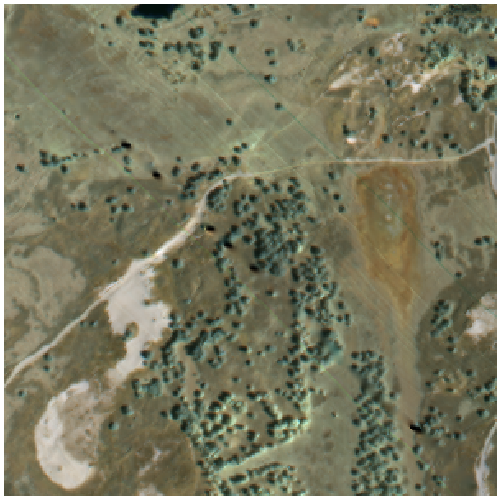

In [145]:
p1 = colorview(RGB,permutedims(rgb,(3,1,2)));
plot(p1, axis=nothing, border=:none, size=(500,500))

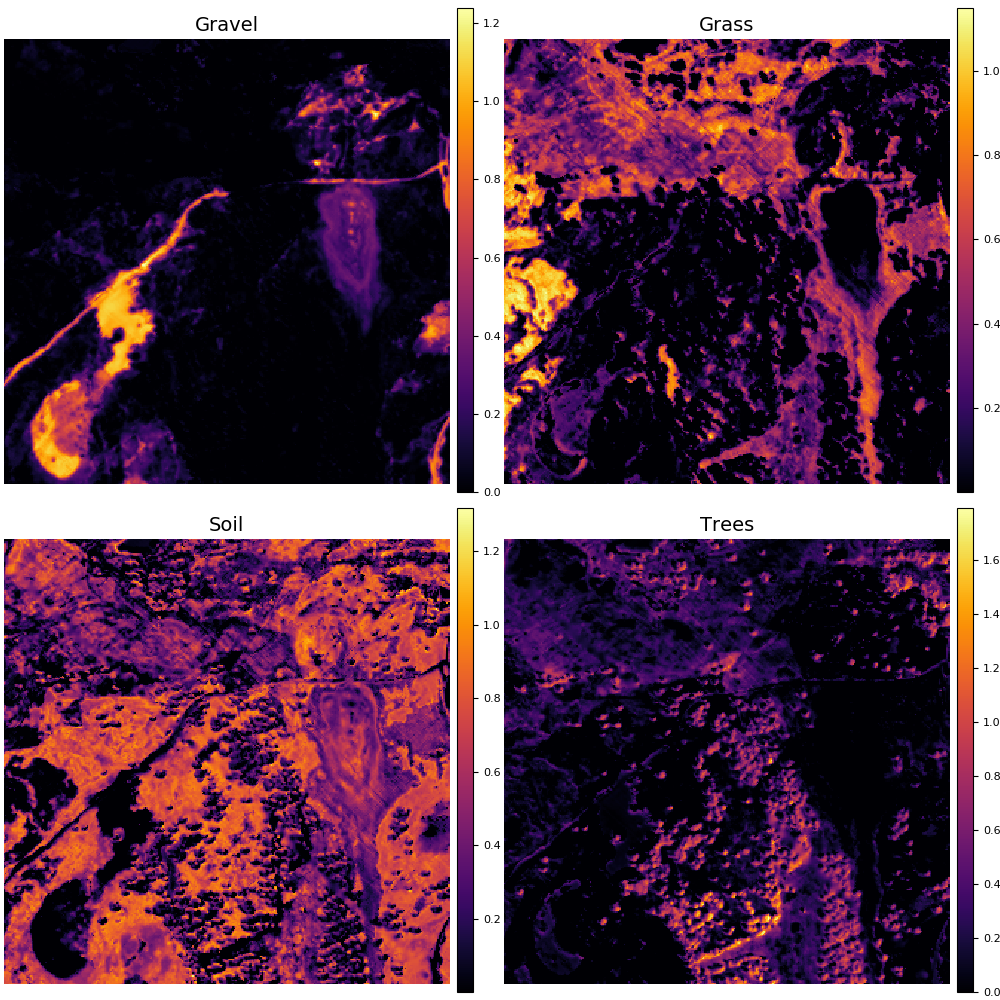

In [146]:
p

## Parallel projected gradient

In [128]:
@everywhere function ParallelProjectedGradient(xi,S,n)
        
    pt             = max.(zeros(n),randn(n))
    nb_iter_grad   = 0  # number of loops
    resu_grad      = pt
    precision = 10^-4
    max_iter = 4000
    delta = 1
    
    t = 2/opnorm(S'*S) #The stepsize is set to two times the reciprocal of the smallest Lipschitz constant
    f(y::Vector)= (1/2)*(norm(S*y-xi))^2
    ∇f(y::Vector)= S'*(S*y-xi)
    
    while norm(delta)>precision && nb_iter_grad<max_iter
        
        nb_iter_grad  += 1;
        yt = pt-t*∇f(pt)
        
        # Projection
        pt_new = max.(zeros(n),yt)
        
        delta = norm(pt-pt_new)
        pt = pt_new
        resu_grad = [resu_grad pt];
    end
    return pt./norm(pt);
end

In [129]:
using Distributed: pmap

p = 4

X_parallel = [X[:,k] for k = 1:N*N];

A = @time pmap(xi->ParallelProjectedGradient(xi,S,n),X_parallel);

  4.448618 seconds (213.33 k allocations: 11.501 MiB, 0.16% gc time)


In [130]:
a_hat_parl_pgd = permutedims(reshape(hcat(A...), (length(A[1]), length(A))));

In [131]:
A1 = reshape(a_hat_parl_pgd[:,1],N,N);
A2 = reshape(a_hat_parl_pgd[:,2],N,N);
A3 = reshape(a_hat_parl_pgd[:,3],N,N);
A4 = reshape(a_hat_parl_pgd[:,4],N,N);

In [132]:
f1 = heatmap(img_small[:,:,67],aspect_ratio=1, yflip = true,c=:inferno, colorbar=:none);
f2 = heatmap(A1,aspect_ratio=1, yflip = true,c=:inferno);
f3 = heatmap(A2,aspect_ratio=1, yflip = true,c=:inferno);
f4 = heatmap(A3,aspect_ratio=1, yflip = true,c=:inferno);
f5 = heatmap(A4,aspect_ratio=1, yflip = true,c=:inferno);

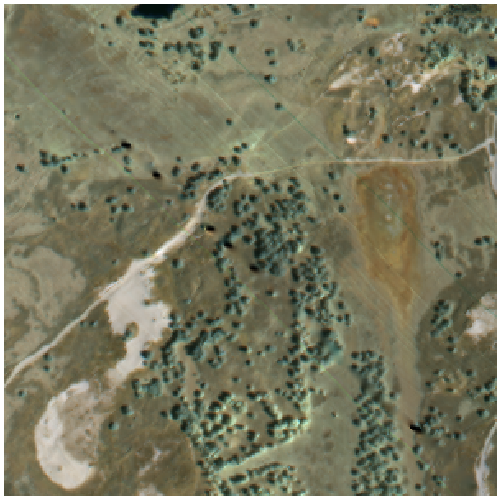

In [136]:
p1 = colorview(RGB,permutedims(rgb,(3,1,2)));
plot(p1, axis=nothing, border=:none, size=(500,500))

In [134]:
p=plot(f2,f3,f4,f5,layout=(2,2), axis=nothing, border=:none, size=(1000,1000));
p.subplots[1].attr[:title]="Gravel";
p.subplots[2].attr[:title]="Grass";
p.subplots[3].attr[:title]="Soil";
p.subplots[4].attr[:title]="Trees";

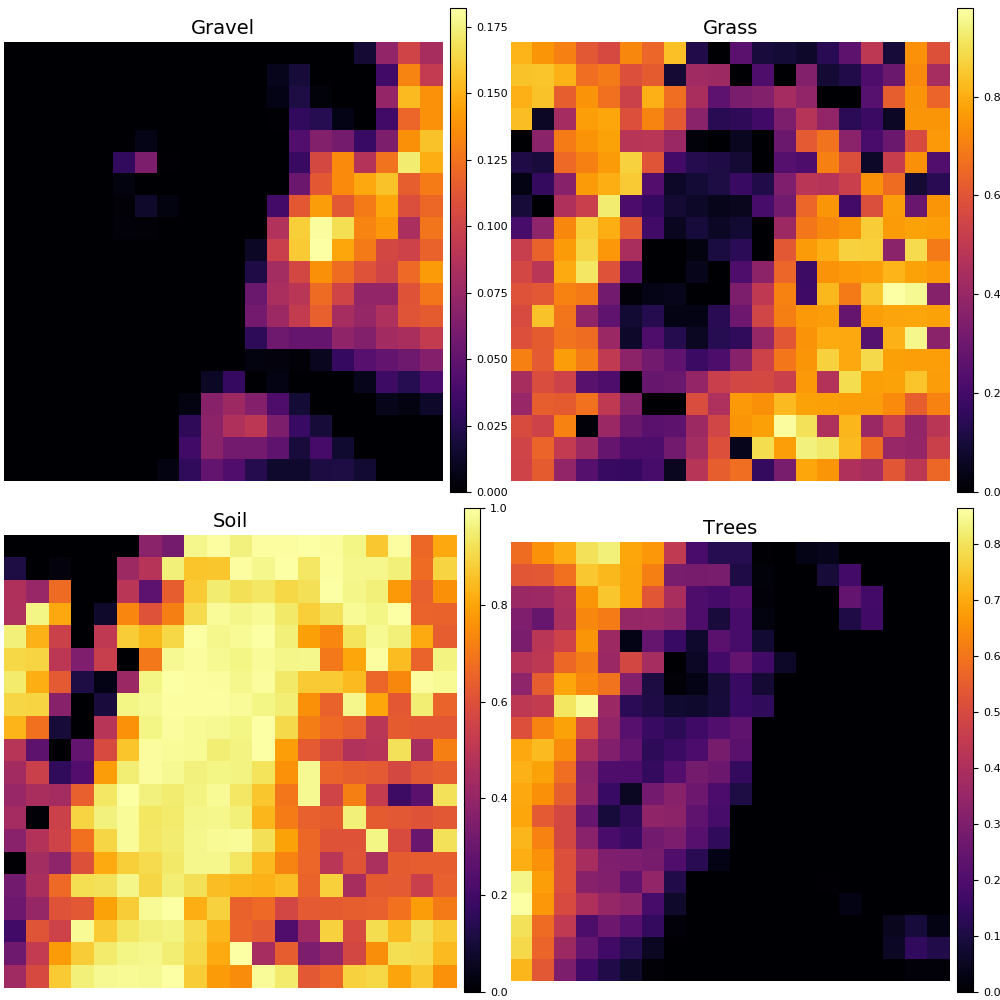

In [135]:
p